In [39]:
from backtesting_engine import BacktestEngine
from Bardata import BarData
import sys
from typing import List
from datetime import datetime, timedelta
import pytz
from kiteconnect import KiteConnect
import pandas as pd
import os

In [40]:
class SSO_strategy(BacktestEngine):
    def __init__(self, config):
        super().__init__(config)
        self.buy = True
        self.closepx = {}
        self.ticks = {}
        self.today = datetime.strptime(config['start_date'], '%Y-%m-%d').date()
        self.start_time = pytz.timezone('Asia/Kolkata').localize(datetime.combine(self.today, datetime.min.time()).replace(hour=9, minute=25, second=0))
        self.end_time = pytz.timezone('Asia/Kolkata').localize(datetime.combine(self.today, datetime.min.time()).replace(hour=10, minute=30, second=0))
        self.executed = {t: False for t in self.trading_symbols.keys()}
        self.high_925 = {}
        self.low_925 = {}
        self.top_gainers = config.get("top_gainers", [])
        self.top_losers = config.get("top_losers", [])

        self.active_orders = {}
        self.option_data = {}
        print(self.trading_symbols)

    def update_bars(self, new_bars: List[BarData]):
        # print(f"Updating {new_bars[0].date} bars")
        for b in new_bars:
            # print(f"Updating bar: {b.date} for instrument {self.trading_symbols[b.instrument_token]}")
            if b.instrument_token not in self.ticks:
                self.ticks[b.instrument_token] = []
            self.ticks[b.instrument_token].append(b)
            if b.instrument_token not in self.closepx:
                self.closepx[b.instrument_token] = []
            self.closepx[b.instrument_token].append(b.close)
            # print(f"Close price for {self.trading_symbols[b.instrument_token]} at {b.date} is {b.close}")
            if b.date > self.start_time and b.instrument_token not in self.high_925:
                print(f"Setting high_925 and low_925 for {self.trading_symbols[b.instrument_token]} at {b.date}")
                self.high_925[b.instrument_token] = max([t.high for t in self.ticks[b.instrument_token][-10:]])
                self.low_925[b.instrument_token] = min([t.low for t in self.ticks[b.instrument_token][-10:]])
            # print("checking all conditions")
            self.check_all_conditions(b)

    def get_option(self,instrument_token,underlying_price,option_type):
        instr_df = pd.DataFrame(self.kite.instruments('NFO'))
        
        instr_tokens = instr_df[instr_df['name'] == self.trading_symbols[instrument_token]]
        expiries = sorted(instr_tokens['expiry'].unique())
        print(f"Available expiries for {self.trading_symbols[instrument_token]}: {expiries}")
        current_month_options = instr_tokens[
            (instr_df['expiry'] == expiries[0]) & 
            (instr_df['instrument_type'].isin(['CE', 'PE']))]
        
        if option_type == 'CE':
            ce_strike = current_month_options[
                            (current_month_options['strike'] >= underlying_price) & 
                            (current_month_options['instrument_type'] == 'CE')
                        ]['strike'].nsmallest(3).nlargest(1)
            ce_tokens = current_month_options[
                            (current_month_options['strike'].isin(ce_strike.values)) & 
                            (current_month_options['instrument_type'] == 'CE')
                        ]['instrument_token'].tolist()
            return ce_tokens[0] if ce_tokens else None
        
        elif option_type == 'PE':
            pe_strike = current_month_options[
                            (current_month_options['strike'] <= underlying_price) & 
                            (current_month_options['instrument_type'] == 'PE')
                        ]['strike'].nlargest(3).nsmallest(1)
            pe_tokens = current_month_options[
                            (current_month_options['strike'].isin(pe_strike.values)) & 
                            (current_month_options['instrument_type'] == 'PE')
                        ]['instrument_token'].tolist()
            return pe_tokens[0] if pe_tokens else None

        return
    
    def check_entry_conditions(self,tick: BarData):
        print(f"Checking entry conditions for {self.trading_symbols[tick.instrument_token]} at {tick.close} on {tick.date}")
        print(f"Current high_925: {self.high_925.get(tick.instrument_token, 0)}")
        print(f"Current low_925: {self.low_925.get(tick.instrument_token, 0)}")
        if tick.close > self.high_925.get(tick.instrument_token, 0) and tick.instrument_token in self.top_gainers:
            print(f"Buy signal for {self.trading_symbols[tick.instrument_token]} at {tick.close} on {tick.date}")
            token = self.get_option(tick.instrument_token, tick.close, 'CE')
            today = tick.date.date().strftime('%Y-%m-%d')

            self.option_data[tick.instrument_token] = self.kite.historical_data(token,today,today,interval='minute')
            # Find the option candle with the same timestamp as tick.date
            print(self.option_data[tick.instrument_token])
            option_candle = next((c for c in self.option_data[tick.instrument_token] if c['date'] == tick.date), None)
            option_candle['instrument_token']=tick.instrument_token
            option_tick = BarData(**option_candle)
            self.trading_symbols[token] = self.trading_symbols[tick.instrument_token] + 'CE'
            if token:
                self.place_order(option_tick, 1, 'BUY', option_tick.close)
                self.active_orders[tick.instrument_token] = token
            else:
                print(f"No suitable CE option found for {self.trading_symbols[tick.instrument_token]} at {tick.close}")
            
            self.executed[tick.instrument_token] = True
            
        
        if tick.close < self.low_925.get(tick.instrument_token, 0) and tick.instrument_token in self.top_losers:

            print(f"BUY signal for {self.trading_symbols[tick.instrument_token]} at {tick.close} on {tick.date}")
            token = self.get_option(tick.instrument_token, tick.close, 'PE')
            today = tick.date.date().strftime('%Y-%m-%d')
            print(token,today)
            self.option_data[tick.instrument_token] = self.kite.historical_data(token,today,today,interval='minute')
            # Find the option candle with the same timestamp as tick.date
            option_candle = next((c for c in self.option_data[tick.instrument_token] if c['date'] == tick.date), None)
            print(self.option_data)
            option_candle['instrument_token']=tick.instrument_token
            option_tick = BarData(**option_candle)
            self.trading_symbols[token] = self.trading_symbols[tick.instrument_token] + 'PE'
            if token:
                self.place_order(option_tick, 1, 'BUY', option_tick.close)
                self.active_orders[tick.instrument_token] = token
            else:
                print(f"No suitable PE option found for {self.trading_symbols[tick.instrument_token]} at {tick.close}")

            self.executed[tick.instrument_token] = True
        return
    
    def check_exit_conditions(self,tick: BarData):
        if tick.instrument_token in self.top_gainers:
            sma_40 = sum(self.closepx[tick.instrument_token][-40:]) / min(40, len(self.closepx[tick.instrument_token]))
            # Check if close price is less than sma_40 for 5 or more consecutive minutes
            if len(self.closepx[tick.instrument_token]) >= 40:
                last_5_closes = self.closepx[tick.instrument_token][-10:]
                if all(px < sma_40 for px in last_5_closes):
                    print(f"Exit signal for {self.trading_symbols[tick.instrument_token]} at {tick.close} on {tick.date} (close < sma_40 for 5+ mins)")
                    option_candle = next((c for c in self.option_data[tick.instrument_token] if c['date'] == tick.date), None)
                    option_candle['instrument_token'] = tick.instrument_token
                    option_tick = BarData(**option_candle)
                    self.place_order(option_tick, 1, 'SELL', option_tick.close)
                    self.executed[tick.instrument_token] = False
        else :
            sma_40 = sum(self.closepx[tick.instrument_token][-40:]) / min(40, len(self.closepx[tick.instrument_token]))
            # Check if close price is greater than sma_40 for 5 or more consecutive minutes
            if len(self.closepx[tick.instrument_token]) >= 40:
                last_5_closes = self.closepx[tick.instrument_token][-10:]
                if all(px > sma_40 for px in last_5_closes):
                    print(f"Exit signal for {self.trading_symbols[tick.instrument_token]} at {tick.close} on {tick.date} (close > sma_40 for 5+ mins)")
                    option_candle = next((c for c in self.option_data[tick.instrument_token] if c['date'] == tick.date), None)
                    option_candle['instrument_token'] = tick.instrument_token
                    option_tick = BarData(**option_candle)
                    self.place_order(option_tick, 1, 'SELL', option_tick.close)
                    self.executed[tick.instrument_token] = False
        return

    def check_all_conditions(self,b):
        if b.date < self.end_time and b.date > self.start_time and not self.executed[b.instrument_token]:
            self.check_entry_conditions(b)
        if self.executed[b.instrument_token] and self.executed[b.instrument_token]:
            self.check_exit_conditions(b)
        return

In [25]:
config = {
    "strategy_name": "SSO",

    "start_date": "2025-05-06",
    "end_date": "2025-05-06",
    "interval": "minute",
    'tokens':[387073],
    # "NSE_symbols": ['BALKRISIND']
    'top_losers': [387073],
}

# if __name__ == "__main__":
ex = SSO_strategy(config)
ex.run()

# ex.get_NFO_tokens(['NIFTY'],[1,2],['FUT'])
# ex.calculate_pnl()

No trading symbols provided for NFO tokens.
No trading symbols provided for NSE tokens.
No trading symbols provided for BSE tokens.
No trading symbols provided for BFO tokens.
Token 387073 not found in NFO instruments.
Token 387073 not found in BSE instruments.
Token 387073 not found in BFO instruments.
{387073: 'INDHOTEL'}
Setting high_925 and low_925 for INDHOTEL at 2025-05-06 09:26:00+05:30
Checking entry conditions for INDHOTEL at 775.8 on 2025-05-06 09:26:00+05:30
Current high_925: 792.6
Current low_925: 773.5
Checking entry conditions for INDHOTEL at 776.35 on 2025-05-06 09:27:00+05:30
Current high_925: 792.6
Current low_925: 773.5
Checking entry conditions for INDHOTEL at 776.7 on 2025-05-06 09:28:00+05:30
Current high_925: 792.6
Current low_925: 773.5
Checking entry conditions for INDHOTEL at 779.7 on 2025-05-06 09:29:00+05:30
Current high_925: 792.6
Current low_925: 773.5
Checking entry conditions for INDHOTEL at 779.75 on 2025-05-06 09:30:00+05:30
Current high_925: 792.6
Curr

/var/folders/cn/tfff3ckj5rgbdz6t7kthy19m0000gn/T/ipykernel_22031/2549434970.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  current_month_options = instr_tokens[
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


{'sharpe_ratio': np.float64(nan), 'max_drawdown': np.float64(-inf)}

In [41]:
kite = KiteConnect(os.getenv("api_key"), os.getenv("access_token"))
instruments=(pd.DataFrame(kite.instruments("NFO")))
instruments_NSE = (pd.DataFrame(kite.instruments("NSE")))

all_stocks = instruments['name'].unique()

def get_instrument_token(symbol):
    try:
        return instruments_NSE[instruments_NSE['tradingsymbol'] == symbol]['instrument_token'].values[0]
    except IndexError:
        # print(f"Instrument token for {symbol} not found.")
        return None
    
def get_all_derivative_token(symbol):
    option_tokens = []
    try:
        tokens = instruments[(instruments['name'] == symbol)]['instrument_token'].values
        # expiries = sorted(instruments[instruments['name'] == symbol]['expiry'].values)
        # expiry = expiries[0] if len(expiries) > 0 else None
        # token = tokens[(tokens['segment'] == 'NFO-OPT')]['instrument_token'].values
        for t in tokens:
            option_tokens.append(t)

    except IndexError:
        print(f"Option token for {symbol} not found.")
        return []
    return option_tokens

def get_option_token(symbol):
    option_tokens = []
    try:
        tokens = instruments[(instruments['name'] == symbol) & (instruments['segment']=='NFO-OPT')]
        expiries = sorted(instruments[instruments['name'] == symbol]['expiry'].values)
        expiry = expiries[0] if len(expiries) > 0 else None
        token = tokens[(tokens['expiry']==expiry)&(tokens['segment'] == 'NFO-OPT')]['instrument_token'].values
        for t in token:
            option_tokens.append(t)

    except IndexError:
        print(f"Option token for {symbol} not found.")
        return []
    return option_tokens


In [42]:
instrument_tokens = [256265]
option_tokens = []
for symbol in all_stocks:
    instrument_token = get_instrument_token(symbol)
    if instrument_token is not None:
        option_tokens += get_option_token(symbol)
        # print(f"Symbol: {symbol}, Instrument Token: {instrument_token}")
        instrument_tokens.append(int(instrument_token))
    else:
        print(f"Symbol: {symbol} not found in instruments.")

Symbol: NIFTY not found in instruments.
Symbol: BANKNIFTY not found in instruments.
Symbol: FINNIFTY not found in instruments.
Symbol: MIDCPNIFTY not found in instruments.
Symbol: NIFTYNXT50 not found in instruments.


['2025-05-26', '2025-05-27', '2025-05-28']
Nifty 10 minute candle: {'date': datetime.datetime(2025, 5, 26, 9, 15, tzinfo=tzoffset(None, 19800)), 'open': 24919.35, 'high': 25039.75, 'low': 24900.5, 'close': 25017.45, 'volume': 0}
Stock: DIVISLAB, Initial OI: 7215100, Final OI: 7367300, OI Change: 2.11%
Stock: HUDCO, Initial OI: 62725125, Final OI: 61887100, OI Change: -1.34%
Stock: IIFL, Initial OI: 25821950, Final OI: 25101650, OI Change: -2.79%
Stock: M&M, Initial OI: 32641975, Final OI: 32538625, OI Change: -0.32%
Stock: SONACOMS, Initial OI: 27069550, Final OI: 28361650, OI Change: 4.77%
Stock: BALKRISIND, Initial OI: 4304700, Final OI: 5454000, OI Change: 26.70%
Stock: ETERNAL, Initial OI: 331203475, Final OI: 357414400, OI Change: 7.91%
Final stocks to trade: [85761, 1304833]
No trading symbols provided for NFO tokens.
No trading symbols provided for NSE tokens.
No trading symbols provided for BSE tokens.
No trading symbols provided for BFO tokens.
Token 85761 not found in NFO ins

/var/folders/cn/tfff3ckj5rgbdz6t7kthy19m0000gn/T/ipykernel_22031/2549434970.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  current_month_options = instr_tokens[


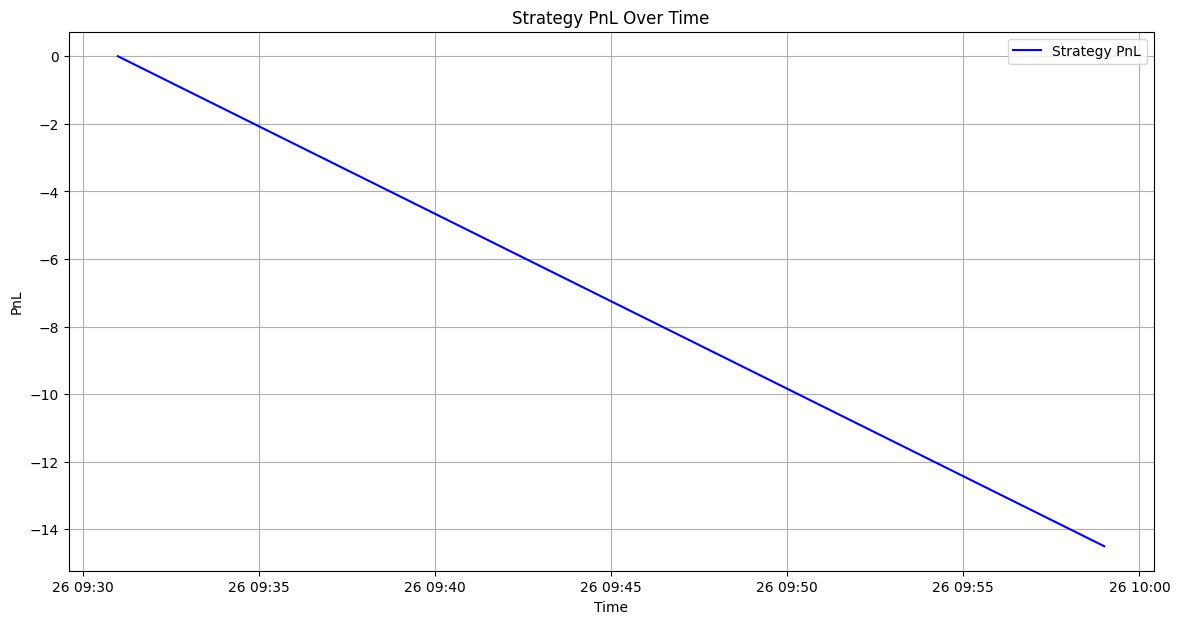

Nifty 10 minute candle: {'date': datetime.datetime(2025, 5, 27, 9, 15, tzinfo=tzoffset(None, 19800)), 'open': 24956.65, 'high': 24976.1, 'low': 24769.3, 'close': 24790.65, 'volume': 0}
Stock: INDIGO, Initial OI: 14787150, Final OI: 17404500, OI Change: 17.70%
Final stocks to trade: [2865921]
No trading symbols provided for NFO tokens.
No trading symbols provided for NSE tokens.
No trading symbols provided for BSE tokens.
No trading symbols provided for BFO tokens.
Token 2865921 not found in NFO instruments.
Token 2865921 not found in BSE instruments.
Token 2865921 not found in BFO instruments.
{2865921: 'INDIGO'}
Setting high_925 and low_925 for INDIGO at 2025-05-27 09:26:00+05:30
Checking entry conditions for INDIGO at 5284.5 on 2025-05-27 09:26:00+05:30
Current high_925: 5303.5
Current low_925: 5264.5
Checking entry conditions for INDIGO at 5286.5 on 2025-05-27 09:27:00+05:30
Current high_925: 5303.5
Current low_925: 5264.5
Checking entry conditions for INDIGO at 5300 on 2025-05-27 0

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

In [ ]:
strt_date = "2025-05-26"
en_date = "2025-05-28"

start = datetime.strptime(strt_date, "%Y-%m-%d")
end = datetime.strptime(en_date, "%Y-%m-%d")

# Generate list of date strings
all_dates = [(start + timedelta(days=i)).strftime("%Y-%m-%d") for i in range((end - start).days + 1)]

print(all_dates)

for date in all_dates:
    start_date = date
    top_gainers = []
    top_losers = []
    for stocks in instrument_tokens:
        data=kite.historical_data(stocks, date, date, "5minute")
        if data is None or len(data) == 0:
            # print(f"No data available for {stocks} on {date}. Skipping...")
            continue
        def get_previous_trading_day(date_str):
            date = datetime.strptime(date_str, "%Y-%m-%d")
            prev_day = date - timedelta(days=1)
            # Skip weekends (Saturday=5, Sunday=6)
            while prev_day.weekday() >= 5:
                prev_day -= timedelta(days=1)
            return prev_day.strftime("%Y-%m-%d")

        previous_trading_day = get_previous_trading_day(date)
        data2 = kite.historical_data(stocks, previous_trading_day, previous_trading_day, "day")
        while data2 is None or len(data2) == 0:
            previous_trading_day = get_previous_trading_day(previous_trading_day)
            data2 = kite.historical_data(stocks, previous_trading_day, previous_trading_day, "day")
        candle = data[0]
        candle2 = data2[0]
        change= (candle['close'] - candle2['close']) / candle2['close'] * 100
        if change > 2:
            top_gainers.append(stocks)
        elif change < -2:
            top_losers.append(stocks)

    nifty10_candle = kite.historical_data(256265, date, date, "10minute")
    if nifty10_candle is None or len(nifty10_candle) == 0:
        # print(f"No 10 minute candle data available for Nifty on {date}. Skipping...")
        continue
    print(f"Nifty 10 minute candle: {nifty10_candle[0]}")
    if nifty10_candle[0]['open']>nifty10_candle[0]['close']:
        top_gainers=[]
        
    stocks_to_trade = top_gainers + top_losers


        
    final_stocks = []

    for stock in stocks_to_trade:
        symbol = instruments_NSE[instruments_NSE['instrument_token'] == stock]['tradingsymbol'].values[0]
        option_token = get_all_derivative_token(symbol)
        initial_oi = 0
        final_oi = 0
        for token in option_token:
            oi_data = kite.historical_data(token, date, date, "10minute",oi=True)
            oi_data2 = kite.historical_data(token, previous_trading_day, previous_trading_day, "day",oi=True)
            initial_oi += oi_data2[0]['oi'] if oi_data2 else 0
            try:
                final_oi += oi_data[0]['oi']
            except IndexError:
                # print(f"OI data for {token}{symbol} not available for the specified date range.")
                continue
            # if oi_data:
            #     initial_oi += oi_data[0]['oi']
            #     final_oi += oi_data[5]['oi']
        oi_change = (final_oi - initial_oi) / initial_oi * 100 if initial_oi != 0 else 0
        if oi_change > 7:
            final_stocks.append(stock)
        print(f"Stock: {symbol}, Initial OI: {initial_oi}, Final OI: {final_oi}, OI Change: {oi_change:.2f}%")


    print(f"Final stocks to trade: {final_stocks}")
    strategy_name = "SSO_8sma_" + date
    config = {
        "strategy_name": strategy_name,

        "start_date": date,
        "end_date": date,
        "interval": "minute",
        'tokens':final_stocks,

        "top_gainers": top_gainers,
        "top_losers": top_losers,
    }

    backtest = SSO_strategy(config)
    try:
        backtest.run()
        backtest.plot_results()
    except Exception as e:
        print(e)
        continue

In [37]:
def get_oi_change(symbol, date):
    option_token = get_all_derivative_token(symbol)
    initial_oi = 0
    final_oi = 0
    for token in option_token:
        previous_trading_day = get_previous_trading_day(date)
        # print(previous_trading_day)
        oi_data = kite.historical_data(token, date, date, "day",oi=True)
        oi_data2 = kite.historical_data(token, previous_trading_day, previous_trading_day, "day",oi=True)
        initial_oi += oi_data2[0]['oi'] if oi_data2 else 0
        try:
            final_oi += oi_data[-1]['oi']
        except IndexError:
            # print(f"OI data for {token}{symbol} not available for the specified date range.")
            continue
    oi_change = (final_oi - initial_oi) / initial_oi * 100 if initial_oi != 0 else 0
    return oi_change

In [38]:
date = '2025-05-28'
get_oi_change('LICI',date)

142.40663771289869

In [ ]:
tkn=get_all_derivative_token('LICI')
# for token in tkn:
    
oi=0
for token in tkn:
    data= kite.historical_data(token,'2025-05-28','2025-05-28','15minute',oi=True)
    # print(data)
    try:
        oi += data[0]['oi']
    except IndexError as e:
        # print(e)
        continue
oi

12853825

In [33]:
# 15407225/575
12853825/575

22354.478260869564

In [34]:
(31647650 - 12853825)/12853825 * 100

146.21192524404213

In [ ]:

# kite = KiteConnect(os.getenv("api_key"), os.getenv("access_token"))
# instruments=(pd.DataFrame(kite.instruments("NFO")))
# instruments_NSE = (pd.DataFrame(kite.instruments("NSE")))

# all_stocks = instruments['name'].unique()
# def get_instrument_token(symbol):
#     try:
#         return instruments_NSE[instruments_NSE['tradingsymbol'] == symbol]['instrument_token'].values[0]
#     except IndexError:
#         print(f"Instrument token for {symbol} not found.")
#         return None
    
# def get_all_option_token(symbol):
#     option_tokens = []
#     try:
#         tokens = instruments[(instruments['name'] == symbol) & (instruments['segment']=='NFO-OPT')]
#         expiries = sorted(instruments[instruments['name'] == symbol]['expiry'].values)
#         expiry = expiries[0] if len(expiries) > 0 else None
#         token = tokens[(tokens['segment'] == 'NFO-OPT')]['instrument_token'].values
#         for t in token:
#             option_tokens.append(t)

#     except IndexError:
#         print(f"Option token for {symbol} not found.")
#         return []
#     return option_tokens

# def get_option_token(symbol):
#     option_tokens = []
#     try:
#         tokens = instruments[(instruments['name'] == symbol) & (instruments['segment']=='NFO-OPT')]
#         expiries = sorted(instruments[instruments['name'] == symbol]['expiry'].values)
#         expiry = expiries[0] if len(expiries) > 0 else None
#         token = tokens[(tokens['expiry']==expiry)&(tokens['segment'] == 'NFO-OPT')]['instrument_token'].values
#         for t in token:
#             option_tokens.append(t)

#     except IndexError:
#         print(f"Option token for {symbol} not found.")
#         return []
#     return option_tokens

# instrument_tokens = [256265]
# option_tokens = []
# for symbol in all_stocks:
#     instrument_token = get_instrument_token(symbol)
#     if instrument_token is not None:
#         option_tokens += get_option_token(symbol)
#         print(f"Symbol: {symbol}, Instrument Token: {instrument_token}")
#         instrument_tokens.append(int(instrument_token))
#     else:
#         print(f"Symbol: {symbol} not found in instruments.")


In [24]:
len(option_tokens), len(instrument_tokens)

(33022, 217)

In [40]:
data=kite.historical_data(
    2865921,
    "2025-05-27",
    "2025-05-27",
    "5minute",
)
data[0]['date'].date().strftime('%Y-%m-%d')

'2025-05-27'

0.027675276752767528

In [25]:


start_date = "2025-05-27"
end_date = "2025-05-27"
top_gainers = []
top_losers = []
for stocks in instrument_tokens:
    data=kite.historical_data(stocks, start_date, end_date, "5minute")
    def get_previous_trading_day(date_str):
        date = datetime.strptime(date_str, "%Y-%m-%d")
        prev_day = date - timedelta(days=1)
        # Skip weekends (Saturday=5, Sunday=6)
        while prev_day.weekday() >= 5:
            prev_day -= timedelta(days=1)
        return prev_day.strftime("%Y-%m-%d")

    previous_trading_day = get_previous_trading_day(start_date)
    data2 = kite.historical_data(stocks, previous_trading_day, previous_trading_day, "day")
    candle = data[0]
    candle2 = data2[0]
    change= (candle['close'] - candle2['close']) / candle2['close'] * 100
    if change>2:
        top_gainers.append(stocks)
    elif change<-2:
        top_losers.append(stocks)

nifty10_candle = kite.historical_data(256265, start_date, end_date, "10minute")
print(f"Nifty 10 minute candle: {nifty10_candle[0]}")
if nifty10_candle[0]['open']>nifty10_candle[0]['close']:
    top_gainers=[]
    
stocks_to_trade = top_gainers + top_losers


    

Nifty 10 minute candle: {'date': datetime.datetime(2025, 5, 27, 9, 15, tzinfo=tzoffset(None, 19800)), 'open': 24956.65, 'high': 24976.1, 'low': 24769.3, 'close': 24790.65, 'volume': 0}


In [26]:
stocks_to_trade

[2865921]

In [ ]:
# final_stocks = []

# for stock in stocks_to_trade:
#     symbol = instruments_NSE[instruments_NSE['instrument_token'] == stock]['tradingsymbol'].values[0]
#     option_token = get_all_derivative_token(symbol)
#     initial_oi = 0
#     final_oi = 0
#     for token in option_token:
#         oi_data = kite.historical_data(token, start_date, end_date, "5minute",oi=True)
#         oi_data2 = kite.historical_data(token, previous_trading_day, previous_trading_day, "day",oi=True)
#         initial_oi += oi_data2[0]['oi'] if oi_data2 else 0
#         try:
#             final_oi += oi_data[0]['oi']
#         except IndexError:
#             print(f"OI data for {token}{symbol} not available for the specified date range.")
#             continue
#         # if oi_data:
#         #     initial_oi += oi_data[0]['oi']
#         #     final_oi += oi_data[5]['oi']
#     oi_change = (final_oi - initial_oi) / initial_oi * 100 if initial_oi != 0 else 0
#     if oi_change > 7:
#         final_stocks.append(stock)
#     print(f"Stock: {symbol}, Initial OI: {initial_oi}, Final OI: {final_oi}, OI Change: {oi_change:.2f}%")


# print(f"Final stocks to trade: {final_stocks}")